# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [0]:
# Change here using YOUR first and last names
fn1 = "enrique"
ln1 = "gomez"
fn2 = "thihaiyen"
ln2 = "vu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_gomez_enrique_and_vu_thihaiyen.ipynb


In [0]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.linalg import svd
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

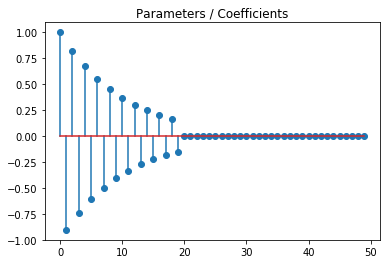

In [0]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [0]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [0]:
A, b = simu_linreg(coefs);
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2_norm penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1_norm penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [0]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(np.absolute(x) - lmbd,0)
    return z

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * norm(x,ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x / (lmbd + 1.)
    return z

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * norm(x,ord=2)**2 / 2

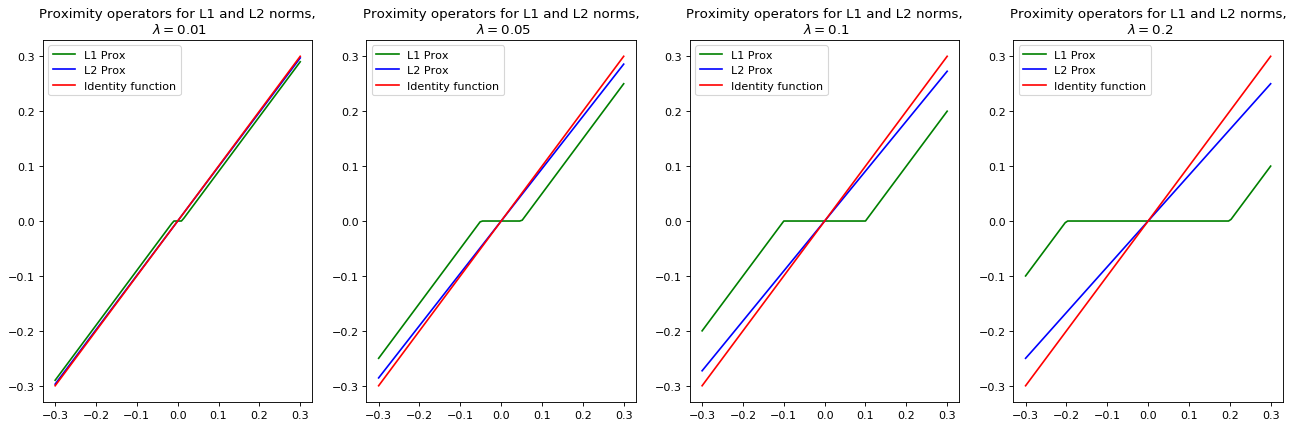

In [0]:
x = np.linspace(-0.3,0.3,100)
i = 141
plt.figure(figsize=(20, 6), dpi=80)
for lmbd in [0.01,0.05,0.1,0.2]:
    plt.subplot(i)
    plt.plot(x,prox_L1(x,lmbd), color = 'g',label='L1 Prox')
    plt.plot(x,prox_L2(x,lmbd), color = 'b',label='L2 Prox')
    plt.plot(x,x,color='r',label='Identity function')
    plt.legend()
    plt.title('Proximity operators for L1 and L2 norms,\n $\lambda=${}'.format(lmbd))
    i +=1

## Comments

We remark that when using a L-1 regularisation, it is like applying a thresholding whose window is parametrized by $\lambda$. That parameter controls the slope of the L-2 proximal operator.

In fact, smaller is alpha, more similar the identity function is from the proximal operators for both norms. Alpha controls the amount of regularization. For a bigger alpha, the thresholding window for L1-noem is wide and the slope for the L2-norm is more positive.

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

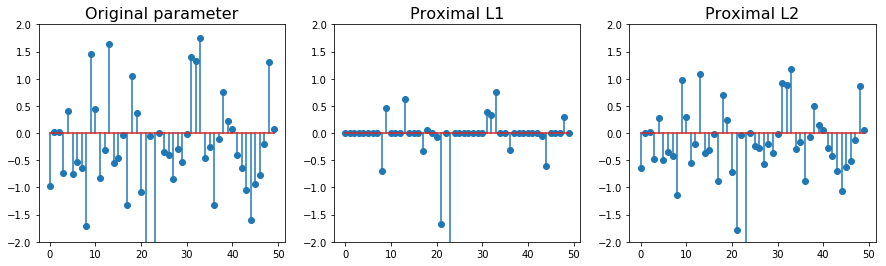

In [0]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

1. **Proximal L1:** The coefficients are shrunk a bit and those below a certain threshold are set to zero. This increase the sparcity of the matrix

2. **Proximal L2:** The coefficients are shrunk as in the above case, but they are not set to zero.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

### Linear Regression

$$
\nabla f = \nabla\frac{1}{2 n} \| b - A x \|_2^2 = -\frac{1}{n} A^\top ( b - A x)
$$

### Logistic Regression

$$
\nabla \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) = \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)}
$$

In [0]:
def loss_linreg(x):
    """Least squares loss"""
    return (norm(b - A @ x) ** 2) / (2.* n_samples)

def grad_linreg(x):
    """Least squares gradient"""
    return - 1./n_samples * A.T @ (b - A @ x)

def loss_logreg(x):
    """Logistic loss"""
    return np.mean(np.log(1+np.exp(-b*(A @ x)))) 

def grad_logreg(x):
    """Logistic gradient"""
    return np.mean(-b* A.T *np.exp(-b*(A @ x))/(1+np.exp(-b*(A @ x))),axis=1)



Text(0.5, 1.0, 'Projection of the two loss on the real axis')

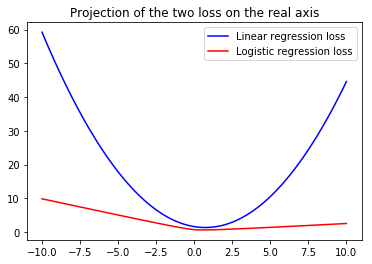

In [0]:
nlinspace = 100
x_norm = np.linspace(-10,10,nlinspace)
x_all_feat = np.zeros((nlinspace,n_features))
x_all_feat[:,0]= x_norm
x_linregloss = [loss_linreg(x_all_feat_elem) for x_all_feat_elem in x_all_feat]
x_logregloss = [loss_logreg(x_all_feat_elem) for x_all_feat_elem in x_all_feat]
plt.plot(x_norm,x_linregloss,color='b',label='Linear regression loss')
plt.plot(x_norm,x_logregloss,color='r',label='Logistic regression loss')
plt.legend()
plt.title('Projection of the two loss on the real axis')

In [0]:
from scipy.optimize import check_grad
x0=randn(n_features)
print("Check_grad value for Linear Regression:",
      check_grad(loss_linreg,grad_linreg,x0))
print("Check_grad value for Logistic Regression:",
      check_grad(loss_logreg,grad_logreg,x0))

Check_grad value for Linear Regression: 3.914260746819561e-06
Check_grad value for Logistic Regression: 1.5641410381385294e-07


We obtain nearly zero values, suggesting that the functions are correct.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

### Linear Regression

If $f(x)$ is L-smooth, then, by definition of $\sigma_{max}$ (maximun eigen value),  we have

$$
  v^\top \nabla ^2 f v = v^\top A^\top A v
 = \| Av\|_2^2 \le \sigma_{max}^2 \|v\|_2^2
$$
 
 where L = $\sigma_{max}^2$
 
### Logistic Regression

Let $\phi: x \rightarrow \log(1 + \exp(-x))$, then our logistic regression function could be written as 

$$
f(x) = \frac{1}{n} \sum_{i=1}^n \phi(b_i a_i^\top x)
$$

Then 

$$
  v^\top A^\top A \frac{\nabla ^2 \phi}{n}v \le \frac{\|\nabla ^2 \phi \|}{n} v^\top A^\top A v
$$

As $$\nabla ^2 \phi(x) = \frac{exp(x)}{(1+exp(x))^2}$$ is concave, its maximum is unique and is atteint when $x=0$

So $\nabla ^2 \phi (0) = \frac{1}{4}$ which is the maximum of that function. So,

$$
   v^\top A^\top A \frac{\nabla ^2 \phi}{n}v \le \frac{1}{4n}\|Av \| \le \frac{1}{4n}\sigma_{max}^2 \|v\|_2^2
$$

So $f(x)$ is L-smooth with $L=\frac{1}{4n}\sigma_{max}^2$

In [0]:

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""
    return norm(A,ord=2)**2 / n_samples
# Calculate the smoothness constant for logistic loss    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    return norm(A,ord=2)**2 / (4 * n_samples)
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_R(x - step * grad_f(x), lmbd * step)
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [0]:

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(z - step * grad_f(z), lmbd * step)
        t_new = (1. + np.sqrt(1. + 4* t**2))/2.
        z = x_new + (t - 1) * (x_new - x) / t_new
        t = t_new
        x = x_new

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [0]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [0]:
# Minimizer of the Linear Regression

A, b = simu_linreg(coefs)

min_L1,ob,er = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 
                    1/smoothness_const_linreg(A), lmbd, n_iter=100, 
                    x_true=coefs, verbose=False)

print("minimizer of the function using the L1-norm: ", min_L1)
print("minimum of the function using the L1-norm: ", loss_linreg(min_L1))



min_L2,ob,er = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 
                    1/smoothness_const_linreg(A), lmbd, n_iter=100, 
                    x_true=coefs, verbose=False)

print("minimizer of the function using the L2-norm: ", min_L2)
print("minimum of the function using the L2-norm: ", loss_linreg(min_L2))

print("true minimum of the function: ", loss_linreg(coefs))


minimizer of the function using the L1-norm:  [ 1.01 -0.94  0.78 -0.67  0.6  -0.47  0.44 -0.43  0.42 -0.39  0.34 -0.31
  0.33 -0.26  0.21 -0.21  0.22 -0.19  0.18 -0.15 -0.03 -0.02  0.   -0.03
  0.    0.01 -0.02 -0.    0.   -0.04  0.03 -0.01 -0.   -0.   -0.04  0.04
 -0.02 -0.    0.    0.02 -0.    0.02  0.03 -0.01 -0.    0.   -0.05  0.03
  0.04  0.04]
minimum of the function using the L1-norm:  0.4643187874972311
minimizer of the function using the L2-norm:  [ 1.01 -0.94  0.78 -0.68  0.61 -0.49  0.46 -0.45  0.44 -0.41  0.37 -0.33
  0.35 -0.28  0.24 -0.23  0.24 -0.21  0.2  -0.16 -0.03 -0.04  0.01 -0.06
  0.01  0.03 -0.04 -0.01  0.01 -0.06  0.06 -0.03 -0.    0.   -0.06  0.07
 -0.04 -0.    0.    0.04 -0.02  0.03  0.05 -0.02 -0.02  0.02 -0.08  0.05
  0.04  0.04]
minimum of the function using the L2-norm:  0.45985358495389916
true minimum of the function:  0.48326201067465746


In [0]:
# Minimizer of the Logistic Regression

A, b = simu_logreg(coefs)

min_L1,ob,er = APGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1, 
                    1/smoothness_const_loreg(A), lmbd, n_iter=100, 
                    x_true=coefs, verbose=False)
print("minimizer of the function using the L1-norm: ", min_L1)
print("minimum of the function using the L1-norm: ", loss_logreg(min_L1))


min_L2,ob,er = APGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 
                    1/smoothness_const_loreg(A), lmbd, n_iter=100, 
                    x_true=coefs, verbose=False)
print("minimizer of the function using the L2-norm: ", min_L2)
print("minimum of the function using the L2-norm: ", loss_logreg(min_L2))

print("true minimum of the function: ", loss_logreg(coefs))

minimizer of the function using the L1-norm:  [ 0.74 -0.73  0.69 -0.55  0.36 -0.31  0.31 -0.29  0.08 -0.2   0.2  -0.13
  0.23 -0.19  0.12 -0.23  0.03 -0.05  0.1  -0.07 -0.05 -0.   -0.    0.
  0.04  0.   -0.09 -0.    0.07  0.    0.    0.   -0.06 -0.    0.    0.03
  0.   -0.    0.   -0.    0.    0.   -0.03 -0.    0.    0.    0.01 -0.
  0.    0.  ]
minimum of the function using the L1-norm:  0.5282187438363571
minimizer of the function using the L2-norm:  [ 0.81 -0.82  0.78 -0.65  0.48 -0.44  0.42 -0.41  0.19 -0.33  0.32 -0.24
  0.36 -0.3   0.22 -0.34  0.16 -0.18  0.22 -0.13 -0.06 -0.08  0.02 -0.01
  0.09  0.08 -0.19 -0.01  0.12 -0.02  0.04  0.02 -0.1  -0.04 -0.    0.12
  0.01 -0.04  0.04 -0.07  0.05  0.02 -0.11  0.   -0.05  0.08  0.08 -0.07
  0.02  0.01]
minimum of the function using the L2-norm:  0.5084175255426262
true minimum of the function:  0.5240046332892503


## Convergence Graphs of PGD and APGD

Text(0.5, 1.0, 'Evolution of the objective function')

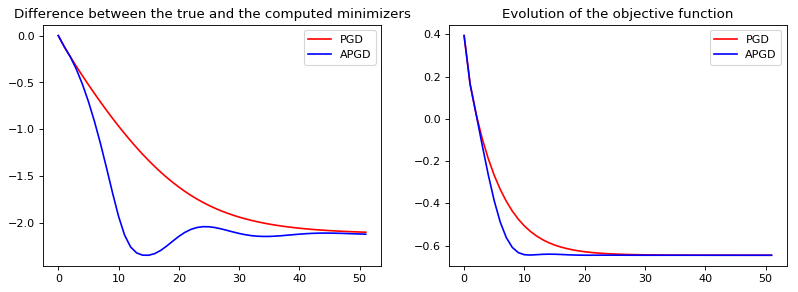

In [0]:
# Convergences - Linear Regression - L1
A, b = simu_linreg(coefs)

min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 
                            1/smoothness_const_linreg(A), lmbd, n_iter=50,
                            x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 
                                1/smoothness_const_linreg(A), lmbd, n_iter=50,
                                x_true=coefs, verbose=False)

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plt.plot(np.log(er_PGD),color='r',label='PGD')
plt.plot(np.log(er_APGD),color='b',label='APGD')
plt.legend()
plt.title('Difference between the true and the computed minimizers')


plt.subplot(122)
plt.plot(np.log(ob_PGD),color='r',label='PGD')
plt.plot(np.log(ob_APGD),color='b',label='APGD')
plt.legend()
plt.title('Evolution of the objective function')


Text(0.5, 1.0, 'Evolution of the objective function')

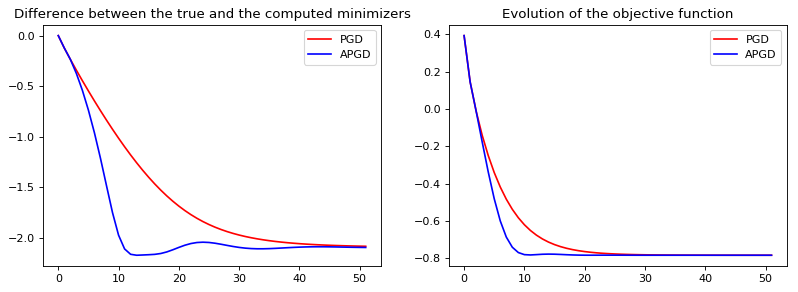

In [0]:
# Convergences - Linear Regression - L2
min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 
             1/smoothness_const_linreg(A), lmbd, n_iter=50, 
             x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 
              1/smoothness_const_linreg(A), lmbd, n_iter=50, 
              x_true=coefs, verbose=False)

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plt.plot(np.log(er_PGD),color='r',label='PGD')
plt.plot(np.log(er_APGD),color='b',label='APGD')
plt.legend()
plt.title('Difference between the true and the computed minimizers')


plt.subplot(122)
plt.plot(np.log(ob_PGD),color='r',label='PGD')
plt.plot(np.log(ob_APGD),color='b',label='APGD')
plt.legend()
plt.title('Evolution of the objective function')

Text(0.5, 1.0, 'Evolution of the objective function')

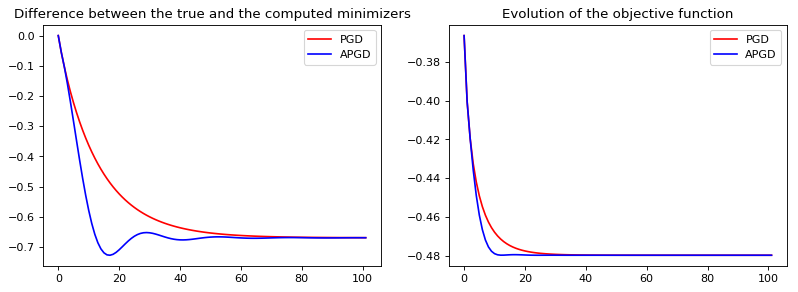

In [0]:
# Convergences - Logistic Regression - L1
A, b = simu_logreg(coefs)
min_PGD,ob_PGD,er_PGD = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,
                                1/smoothness_const_loreg(A), lmbd, n_iter=100,
                                x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,
                                1/smoothness_const_loreg(A), lmbd, n_iter=100,
                                x_true=coefs, verbose=False)

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plt.plot(np.log(er_PGD),color='r',label='PGD')
plt.plot(np.log(er_APGD),color='b',label='APGD')
plt.legend()
plt.title('Difference between the true and the computed minimizers')


plt.subplot(122)
plt.plot(np.log(ob_PGD),color='r',label='PGD')
plt.plot(np.log(ob_APGD),color='b',label='APGD')
plt.legend()
plt.title('Evolution of the objective function')

Text(0.5, 1.0, 'Evolution of the objective function')

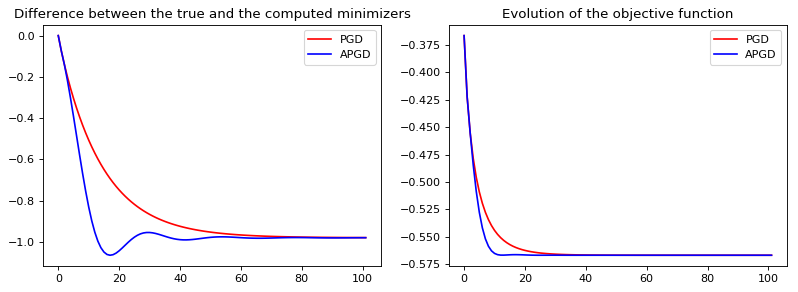

In [0]:
# Convergences - Logistic Regression - L2
min_PGD,ob_PGD,er_PGD = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 
              1/smoothness_const_loreg(A), lmbd, n_iter=100,
              x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 
              1/smoothness_const_loreg(A), lmbd, n_iter=100,
              x_true=coefs, verbose=False)

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plt.plot(np.log(er_PGD),color='r',label='PGD')
plt.plot(np.log(er_APGD),color='b',label='APGD')
plt.legend()
plt.title('Difference between the true and the computed minimizers')

plt.subplot(122)
plt.plot(np.log(ob_PGD),color='r',label='PGD')
plt.plot(np.log(ob_APGD),color='b',label='APGD')
plt.legend()
plt.title('Evolution of the objective function')


## Commentaries

- It is clear from the plots that the APGD converges much quicker than the PGD,  both for the minimum and the minimizer. The convergence is bumpy as it is seen in the graph. It is due to the momentum added to the gradient.

- Logistic  regression provides in both cases a quicker and better convergence. It is certainly due to the nature of the features. They have an exponential nature.

- A L-1 regularisation gives a bumpier convergence as seen in the graphs, this is probably because that function is not as smooth as the L-2 regularsation

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

In [0]:
def get_params(problem, regu,corr=0.5):
    """
        problem: 'linreg' or 'logreg'
        regu: 'L1' or 'L2'
    """
    if problem == 'linreg':
        A, b = simu_linreg(coefs,corr=corr);
        step = 1. / smoothness_const_linreg(A)
        f_loss = loss_linreg
        grad_f_loss = grad_linreg
    elif problem == 'logreg':
        A, b = simu_logreg(coefs,corr=corr);
        step = 1. / smoothness_const_loreg(A)
        f_loss = loss_logreg
        grad_f_loss = grad_logreg
    
    if regu == 'L1':
        R_norm = L1_norm
        R_prox = prox_L1
    elif regu == 'L2':
        R_norm = L2_norm
        R_prox = prox_L2
    
    return A, b, f_loss, grad_f_loss, R_norm, R_prox, step

## Compare the solutions of the two methods with the true coefficients.

In [0]:
A, b, f_loss, grad_f_loss, R_norm, R_prox, step = get_params('logreg', 'L2')

x_pgd,_,_ = PGD(x0, f_loss, grad_f_loss, R_norm, R_prox, step, lmbd, 
                n_iter=500,x_true=coefs, verbose=False)
x_apgd,_,_ = APGD(x0, f_loss, grad_f_loss, R_norm, R_prox, step, lmbd, 
                  n_iter=500,x_true=coefs, verbose=False)

print("x obtained by PDG method:",x_pgd)
print("x obtained by APDG method:",x_apgd)

x obtained by PDG method: [ 0.97 -0.75  0.69 -0.7   0.63 -0.6   0.46 -0.4   0.36 -0.37  0.25 -0.18
  0.3  -0.09 -0.03 -0.19  0.14 -0.07  0.19 -0.03 -0.09  0.01 -0.05 -0.06
  0.07 -0.    0.02 -0.02  0.05 -0.12  0.07  0.03 -0.17  0.24 -0.13 -0.05
  0.02  0.07  0.09 -0.09  0.07 -0.02 -0.07  0.07 -0.07 -0.07  0.08 -0.21
  0.08 -0.12]
x obtained by APDG method: [ 0.97 -0.75  0.69 -0.7   0.63 -0.6   0.46 -0.4   0.36 -0.37  0.25 -0.18
  0.3  -0.09 -0.03 -0.19  0.14 -0.07  0.19 -0.03 -0.09  0.01 -0.05 -0.06
  0.07 -0.    0.02 -0.02  0.05 -0.12  0.07  0.03 -0.17  0.24 -0.13 -0.05
  0.02  0.07  0.09 -0.09  0.07 -0.02 -0.07  0.07 -0.07 -0.07  0.08 -0.21
  0.08 -0.12]


We see that the solutions of the two methods (almost) coincide. Let's compare with the true parameters of the model !

x true: [ 1.   -0.9   0.82 -0.74  0.67 -0.61  0.55 -0.5   0.45 -0.41  0.37 -0.33
  0.3  -0.27  0.25 -0.22  0.2  -0.18  0.17 -0.15  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.  ]
minimum obtained by the proximal methods:  0.5249606142714144
value of the function with true coefs:  0.5486683148307064


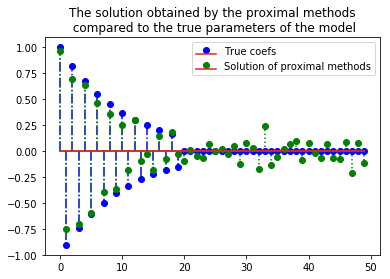

In [0]:
print("x true:",coefs)

print("minimum obtained by the proximal methods: ", f_loss(x_apgd) + R_norm(x_apgd,lmbd))
print("value of the function with true coefs: ", f_loss(coefs)+ R_norm(coefs,lmbd))

markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
plt.setp(markerline, color='b')
plt.setp(stemlines, color='b')
plt.setp(stemlines, linestyle='-.')

markerline, stemlines, baseline = plt.stem(x_apgd,label='Solution of proximal methods')
plt.setp(markerline, color='g')
plt.setp(stemlines, color='g')
plt.setp(stemlines, linestyle=':')

plt.legend()
plt.title('The solution obtained by the proximal methods\n compared to the true parameters of the model')

plt.show()

## Influence of the correlation of the features.

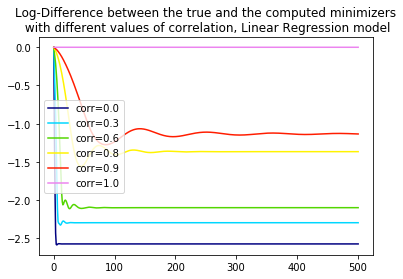

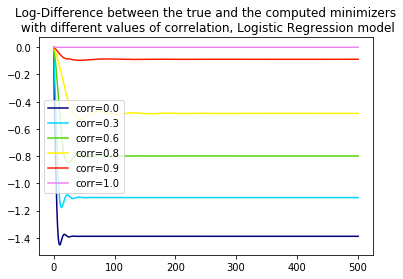

In [0]:
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 0.9,6 )]
for prob in ['linreg','logreg']:
    i=0
    for corr in [0.,0.3,0.6,0.8,0.9,1.0]:
        A, b, f_loss, grad_f_loss, R_norm, R_prox, step = get_params(prob, 'L1',corr=corr)

        x_APGD,ob_APGD,er_APGD = APGD(x0, f_loss, grad_f_loss, R_norm, R_prox, step, lmbd, 
                      n_iter=500,x_true=coefs, verbose=False)

        plt.plot(np.log(er_APGD),color=colors[i],label='corr={}'.format(corr))
        i+=1
    
    if prob == 'linreg':
        model = 'Linear Regression'
    elif prob == 'logreg':
        model = 'Logistic Regression'
    plt.title('Log-Difference between the true and the computed minimizers\n with different values of correlation, {} model'.format(model))
    plt.legend()
    plt.show()



*   We see in both cases that as the correlation of the features increases, the optimization algorithm finds it hard to reach the true coefficients of the model.
*   Then, if we increase the correlation, the points become much closer and therefore it is hard to differenciate the labels of different datapoints. This also implies the fact that rescaling data helps with learning the parameters.





## Influence of the level of L2 penalization.

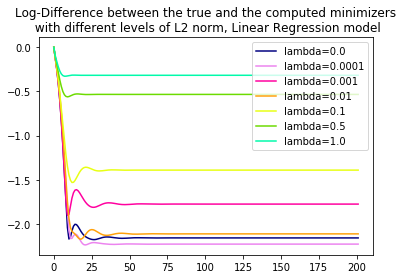

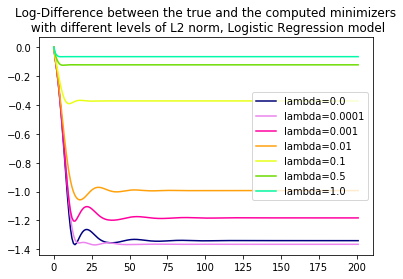

In [0]:
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 0.9,8 )]
for prob in ['linreg','logreg']:
    i=0
    A, b, f_loss, grad_f_loss, R_norm, R_prox, step = get_params(prob, 'L2')
    
    for lmbda in [0.,0.0001,0.001,0.01,0.1,0.5,1.]:

        x_APGD,ob_APGD,er_APGD = APGD(x0, f_loss, grad_f_loss, R_norm, R_prox, step, lmbd=lmbda, 
                      n_iter=200,x_true=coefs, verbose=False)

        plt.plot(np.log(er_APGD),color=colors[i],label='lambda={}'.format(lmbda))
        i-=1

    if prob == 'linreg':
        model = 'Linear Regression'
    elif prob == 'logreg':
        model = 'Logistic Regression'
    plt.title('Log-Difference between the true and the computed minimizers\n with different levels of L2 norm, {} model'.format(model))
    plt.legend()
    plt.show()

* We see that when the $\lambda$ is greater than a certain threshold (0.1 in this case), the algorithm became worse. And the algorithm works generally well when $\lambda$ is small, and in some cases it manages to achieve better results than normal Gradient Decent method ($\lambda=0$). <br/>
* The reason for this is when $\lambda$ is too large, the regularizator term becomes too important with respect to the loss function, hence the optimizer fails to obtain the true parameters of the model. Another explanation is that larger values of $\lambda$ tend to shrink the coefficients as seen above.

## Compare the performance of the optimization algorithms for L2 and L1 penalizations.

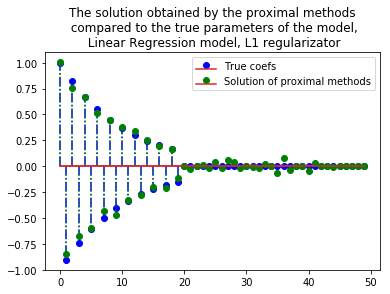

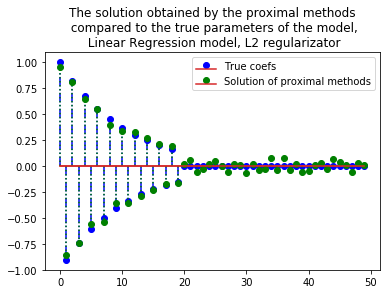

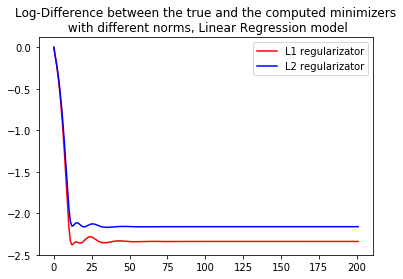

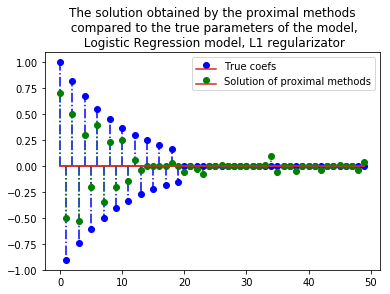

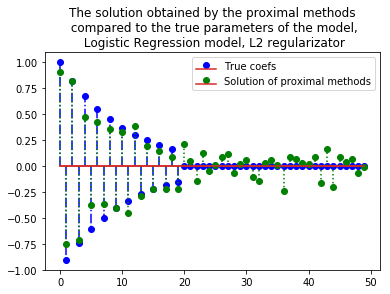

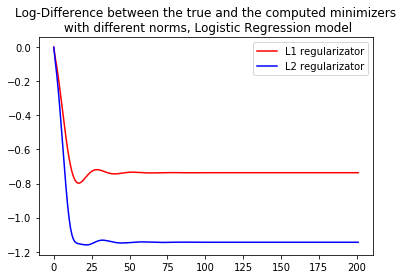

In [0]:
colors = ['b','r']
for prob in ['linreg','logreg']:
    
    if prob == 'linreg':
        model = 'Linear Regression'
    elif prob == 'logreg':
        model = 'Logistic Regression'
        
    errs=[]
    for reg in ['L1','L2']:
        A, b, f_loss, grad_f_loss, R_norm, R_prox, step = get_params(prob, reg)

        x_APGD,ob_APGD,er_APGD = APGD(x0, f_loss, grad_f_loss, R_norm, R_prox, step, lmbd, 
                      n_iter=200,x_true=coefs, verbose=False)
        
        plt.figure()
        markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
        plt.setp(markerline, color='b')
        plt.setp(stemlines, color='b')
        plt.setp(stemlines, linestyle='-.')

        markerline, stemlines, baseline = plt.stem(x_APGD,label='Solution of proximal methods')
        plt.setp(markerline, color='g')
        plt.setp(stemlines, color='g')
        plt.setp(stemlines, linestyle=':')

        plt.legend()
        plt.title('The solution obtained by the proximal methods\n compared to the true parameters of the model,\n {} model, {} regularizator'.format(model, reg))

        plt.show()
        errs.append(er_APGD)

    plt.plot(np.log(errs[0]),color='r',label='L1 regularizator')
    plt.plot(np.log(errs[1]),color='b',label='L2 regularizator')
    plt.title('Log-Difference between the true and the computed minimizers\n with different norms, {} model'.format(model))
    plt.legend()
    plt.show()

* We observe that generally the L2-penalization works better than the L1-norm, especially for the Logistic Regression. <br/>
* The reason might be because the L1 penalization tends to shrink the coefficients, hence the effect.